In [11]:
from collections import namedtuple
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, make_scorer

import presentation as p

# reading in relevant data frames

training_df_scaled_enc_le_clean = pd.read_csv('data/training_df_scaled_enc_le_clean.csv', index_col=None)
training_df_enc_le_clean = pd.read_csv('data/training_df_enc_le_clean.csv', index_col=None)
testing_df_scaled_enc_le_clean = pd.read_csv('data/testing_df_scaled_enc_le_clean.csv', index_col=None)
testing_df_enc_le_clean = pd.read_csv('data/testing_df_enc_le_clean.csv', index_col=None)

X_train_is_attack = training_df_scaled_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1)
X_train_attack_group = training_df_enc_le_clean[training_df_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
y_train_is_attack = training_df_scaled_enc_le_clean.is_attack
y_train_attack_group = training_df_enc_le_clean[training_df_enc_le_clean.is_attack].target_group
X_test_is_attack = testing_df_scaled_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1)
X_test_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
y_true_is_attack = testing_df_scaled_enc_le_clean.is_attack
y_true_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].target_group

# Metrics
beta = 10
fbeta_average = 'weighted'

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.blues_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.purples_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

eval_result = namedtuple('Evaluation', ['model', 'accuracy', 'fbeta'])

def evaluate_model(model, X_test, y_true, beta=beta, average=fbeta_average, display_false_negatives=False):
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    if display_false_negatives:
        total_attacks = y_true.value_counts().iloc[1]
        confusion = confusion_matrix(y_true, pred)
        false_negatives = confusion[1, 0]
        print(f'False negatives: {false_negatives} ({100 * false_negatives / total_attacks:.3f}% out of {total_attacks} attacks, {100 * false_negatives / len(y_true):.3f}% overall)\n')
    return eval_result(model, acc, fbeta)

We found the best random forest classifier on the reduced dataset with the following details:

## Attack Detection

```txt
-- Training Results --
Best Parameters:
	n_jobs:	-1
	n_neighbors:	20
	weights:	distance
Best Score:
	0.996397

-- Testing Results --
Accuracy    on Verification Data:	0.926628
Fbeta scroe on Verification Data:	0.926530

              precision    recall  f1-score   support

       False       0.90      0.99      0.94     47913
        True       0.98      0.82      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291
```

## Attack Classification

```txt
-- Training Results --
Best Parameters:
	n_jobs:	-1
	n_neighbors:	100
	weights:	uniform
Best Score:
	0.977412

-- Testing Results --
Accuracy    on Verification Data:	0.854245
Fbeta scroe on Verification Data:	0.853874

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     23747
           2       0.42      0.67      0.52      3041
           3       0.90      0.18      0.30      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.85     29378
   macro avg       0.57      0.45      0.44     29378
weighted avg       0.88      0.85      0.84     29378
```

Now, we will use this parameterset and train the classifier on the entire dataset.

In [12]:
model_is_attack = KNeighborsClassifier(
    n_neighbors=20,
    weights='distance',
    n_jobs=-1
).fit(X_train_is_attack, y_train_is_attack)

In [13]:
y_pred_is_attack = model_is_attack.predict(X_test_is_attack)

In [14]:
result_is_attack = evaluate_model(model_is_attack, X_test_is_attack, y_true_is_attack, display_false_negatives=True)


-- Testing Results --
Accuracy    on Verification Data:	0.926175
Fbeta scroe on Verification Data:	0.926098

              precision    recall  f1-score   support

       False       0.91      0.98      0.94     47913
        True       0.97      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.92     77291

False negatives: 4885 (16.628% out of 29378 attacks, 6.320% overall)



In [15]:
_ = evaluate_model(model_is_attack, X_test_is_attack, y_true_is_attack, average='binary')


-- Testing Results --
Accuracy    on Verification Data:	0.926175
Fbeta scroe on Verification Data:	0.834863

              precision    recall  f1-score   support

       False       0.91      0.98      0.94     47913
        True       0.97      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.92     77291



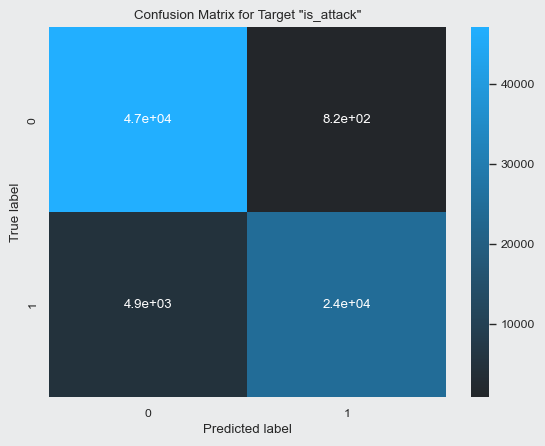

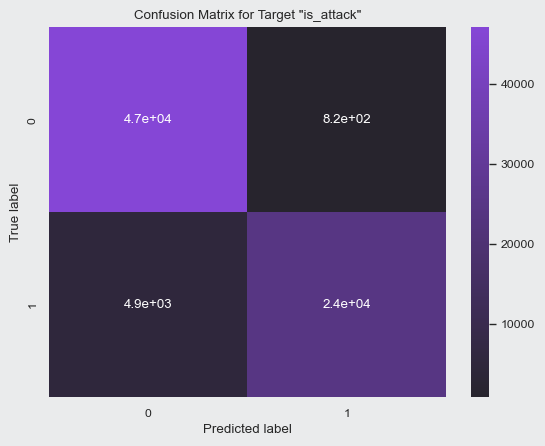

In [16]:
simple_confusion_matrix(y_true_is_attack, y_pred_is_attack, 'is_attack')

In [17]:
model_attack_group = KNeighborsClassifier(
    n_neighbors=100,
    weights='uniform',
    n_jobs=-1
).fit(X_train_attack_group, y_train_attack_group)

In [18]:
y_pred_attack_group = model_attack_group.predict(X_test_attack_group)

In [19]:
result_attack_group = evaluate_model(model_attack_group, X_test_attack_group, y_true_attack_group)


-- Testing Results --
Accuracy    on Verification Data:	0.851181
Fbeta scroe on Verification Data:	0.850764

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     23747
           2       0.48      0.50      0.49      3041
           3       0.83      0.25      0.39      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.85     29378
   macro avg       0.55      0.43      0.45     29378
weighted avg       0.85      0.85      0.84     29378



/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [20]:
result_attack_group = evaluate_model(model_attack_group, X_test_attack_group, y_true_attack_group, average='macro')


-- Testing Results --
Accuracy    on Verification Data:	0.851181
Fbeta scroe on Verification Data:	0.429017

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     23747
           2       0.48      0.50      0.49      3041
           3       0.83      0.25      0.39      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.85     29378
   macro avg       0.55      0.43      0.45     29378
weighted avg       0.85      0.85      0.84     29378



/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

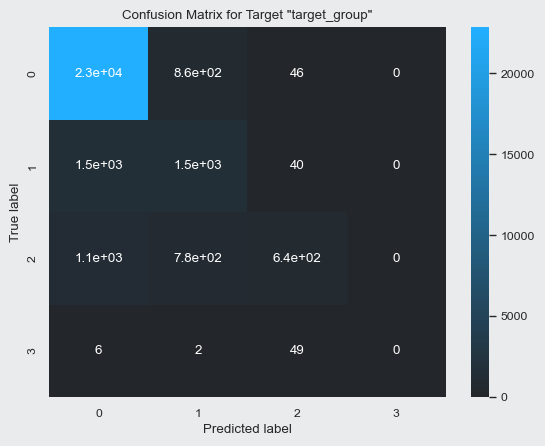

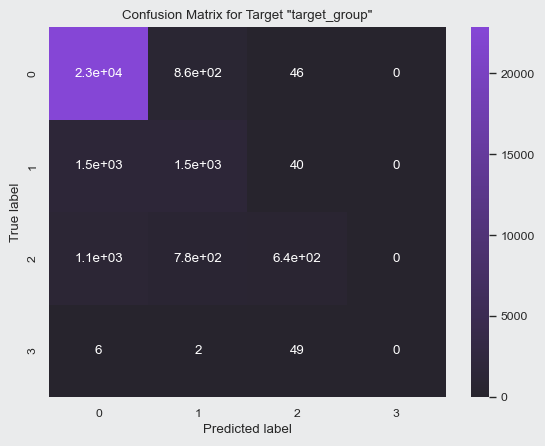

In [21]:
simple_confusion_matrix(y_true_attack_group, y_pred_attack_group, 'target_group')